In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

import sys
sys.path.append('../../wuchengzhou')
import sagan


In [4]:
def generate_continuum(wave):
    # Generate random parameters for the power law
    amp1 = 5 * np.random.rand()
    amp2 = np.random.rand()
    alpha = np.random.uniform(0, 2)
    stddev = np.random.uniform(500, 2500)
    z = np.random.uniform(0, 0.01)
    
    # Create the model
    pl_amps = models.PowerLaw1D(amplitude=amp1, x_0=5500, alpha=alpha, fixed={'x_0': True})
    iron = sagan.IronTemplate(amplitude=amp2, stddev=stddev, z=z, name='Fe II')
    model = pl_amps + iron
    flux = model(wave)
    
    # Add noise
    noise = np.random.normal(0, 0.05, wave.size)
    flux += noise
    
    return flux

In [5]:
def generate_spec(wave):
    flux = generate_continuum(wave)
    
    # Generate random parameters for the emission lines
    nlines = np.random.randint(1, 6)
    for i in range(nlines):
        amp_c = 5 * np.random.rand()
        wavec = np.random.uniform(4300, 6700)
        sigma_c = np.random.uniform(0, 3000)
        line = sagan.Line_Gaussian(amplitude=amp_c, wavec=wavec, sigma=sigma_c)
        
        flux += line(wave)
    
    return flux

In [ ]:
wave = np.linspace(4150, 7000, num=2000)
flux = generate_spec(wave)
plt.plot(wave, flux)
plt.show()

In [ ]:
wave_flux_pairs = []

for _ in range(10000):
    wave = np.linspace(4150, 7000, num=2000)
    flux = generate_spec(wave)
    wave_flux_pairs.append((wave, flux))
    
np.savez('data_generated/wave_flux_data.npz', wave_flux_pairs=wave_flux_pairs)

In [11]:
data_path = 'data_generated/wave_flux_data.npz'
data = np.load(data_path)
wave_flux = data['wave_flux_pairs']
print(wave_flux)

[[[4.15000000e+03 4.15142571e+03 4.15285143e+03 ... 6.99714857e+03
   6.99857429e+03 7.00000000e+03]
  [4.65254178e+00 4.68940805e+00 4.66631675e+00 ... 4.24684885e+00
   4.38648560e+00 4.24140116e+00]]

 [[4.15000000e+03 4.15142571e+03 4.15285143e+03 ... 6.99714857e+03
   6.99857429e+03 7.00000000e+03]
  [4.86833635e+00 4.87856101e+00 4.85435032e+00 ... 1.92586524e+00
   1.89426926e+00 1.92389229e+00]]

 [[4.15000000e+03 4.15142571e+03 4.15285143e+03 ... 6.99714857e+03
   6.99857429e+03 7.00000000e+03]
  [4.63328745e+00 4.52473337e+00 4.55668381e+00 ... 4.24470166e+00
   4.22505127e+00 4.23068401e+00]]

 ...

 [[4.15000000e+03 4.15142571e+03 4.15285143e+03 ... 6.99714857e+03
   6.99857429e+03 7.00000000e+03]
  [8.77517931e-01 9.71445550e-01 9.84231822e-01 ... 7.63751484e-01
   7.31502038e-01 7.88441823e-01]]

 [[4.15000000e+03 4.15142571e+03 4.15285143e+03 ... 6.99714857e+03
   6.99857429e+03 7.00000000e+03]
  [6.78979002e-01 7.00330077e-01 6.38512697e-01 ... 2.31353770e-01
   1.57578

In [14]:
wave = wave_flux[0][0, :]
flux = wave_flux[0][1, :]
print(wave, flux)

[4150.         4151.42571286 4152.85142571 ... 6997.14857429 6998.57428714
 7000.        ] [4.65254178 4.68940805 4.66631675 ... 4.24684885 4.3864856  4.24140116]


______________________________________________

### generate spec

In [279]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import torch

import sys
sys.path.append('../../wuchengzhou')
import sagan

wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

uniform = np.random.uniform
normal = np.random.normal

In [330]:
def pnormal(mean, stddev):
        while True:
            value = normal(mean, stddev)
            if value >= 0:  # 确保值不为负
                return value

def generate_continuum(wave):
    # Generate random parameters for the power law
    amp1 = 10 * np.random.rand()
    amp2 = np.random.rand()
    alpha = uniform(0, 2)
    stddev = uniform(500, 2500)
    z = uniform(0, 0.01)
    
    # Create the model
    pl_amps = models.PowerLaw1D(amplitude=amp1, x_0=5500, alpha=alpha, fixed={'x_0': True})
    iron = sagan.IronTemplate(amplitude=amp2, stddev=stddev, z=z, name='Fe II')
    model = pl_amps + iron
    flux = model(wave)
    
    # Add noise
    noise = np.random.normal(0, 0.1, wave.size)
    flux += noise
    
    return flux

# narrow Line with 2 components
# Hb:2, oIII:2, narrow: 1, Ha: 2
def generate_spec(wave, arg_dict):

    amp_c0 = arg_dict['line_o3']['amp_c0']
    dv_c = arg_dict['line_o3']['dv_c']
    sigma_c = arg_dict['line_o3']['sigma_c']
    amp_w0 = arg_dict['line_o3']['amp_w0']
    dv_w0 = arg_dict['line_o3']['dv_w0']
    sigma_w0 = arg_dict['line_o3']['sigma_w0']

    line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=amp_c0, amp_c1=0.2, dv_c=dv_c, sigma_c=sigma_c, wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]', amp_w0=amp_w0, dv_w0=dv_w0, sigma_w0=sigma_w0)
    
    def tie_o3(model):
        return model['[O III]'].amp_c0 / 2.98
    line_o3.amp_c1.tied = tie_o3
    
    n_ha = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['n_ha']['amp_c'], wavec=wave_dict['Halpha'], name=f'narrow {label_dict["Halpha"]}')
    n_hb = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['n_hb']['amp_c'], wavec=wave_dict['Hbeta'], name=f'narrow {label_dict["Hbeta"]}')
    n_hg = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['n_hc']['amp_c'], wavec=wave_dict['Hgamma'], name=f'narrow {label_dict["Hgamma"]}')

    
    b_HeI = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['b_HeI']['amp_c'], dv_c=arg_dict['b_HeI']['dv_c'], sigma_c=arg_dict['b_HeI']['sigma_c'], wavec=5875.624, name=f'He I 5876')
    
    b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=arg_dict['b_ha']['amp_c'], dv_c=arg_dict['b_ha']['dv_c'], sigma_c=arg_dict['b_ha']['sigma_c'], wavec=wave_dict['Halpha'], name=label_dict['Halpha'], amp_w0=arg_dict['b_ha']['amp_w0'], sigma_w0=arg_dict['b_ha']['sigma_w0'], dv_w0=arg_dict['b_ha']['dv_w0'])
    b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=arg_dict['b_hb']['amp_c'], dv_c=arg_dict['b_hb']['dv_c'], sigma_c=arg_dict['b_hb']['sigma_c'], wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'], amp_w0=arg_dict['b_hb']['amp_w0'], dv_w0=arg_dict['b_hb']['dv_w0'], sigma_w0=arg_dict['b_hb']['sigma_w0'])
    b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['b_hg']['amp_c'], dv_c=arg_dict['b_hg']['dv_c'], sigma_c=arg_dict['b_hg']['sigma_c'], wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])
    
    def tie_narrow_sigma_c(model):
        return model['[O III]'].sigma_c

    def tie_narrow_dv_c(model):
        return model['[O III]'].dv_c

    for line in [n_ha, n_hb, n_hg]:
        line.sigma_c.tied = tie_narrow_sigma_c
        line.dv_c.tied = tie_narrow_dv_c
    
    line_ha = b_ha + n_ha
    line_hb = b_hb + n_hb
    line_hg = b_hg + n_hg

    # def model
    model = (line_ha + line_hb + line_hg + line_o3 + b_HeI)
    
    # Add Gaussian noise
    noise = np.random.normal(0, 0.015, wave.size)
    
    flux = model(wave) + noise
    
    return flux

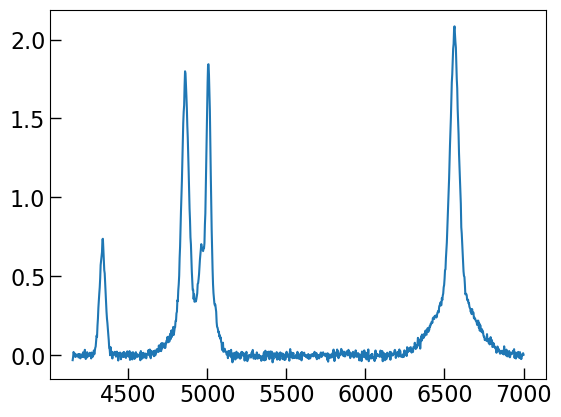

In [370]:
wave = np.linspace(4150, 7000, num=1000)

arg_dict = {'b_ha': {'amp_c':uniform(1.5, 2.5), 'sigma_c':uniform(1200, 1600), 'dv_c':normal(0, 75), 'amp_w0':uniform(0.05, 0.6), 'dv_w0':normal(0, 400), 'sigma_w0':pnormal(5000, 400)}, 'b_hb': {'amp_c':uniform(0.7, 1.7), 'sigma_c':pnormal(1500, 200), 'dv_c':normal(0, 75), 'amp_w0':uniform(0.05, 0.3), 'dv_w0':normal(0, 100), 'sigma_w0':pnormal(5000, 450)}, 'b_hg': {'amp_c':uniform(0.4, 0.9), 'sigma_c':pnormal(1500, 200), 'dv_c':normal(0, 75)}, 'n_ha':{'amp_c':pnormal(0.1, 0.05)}, 'n_hb':{'amp_c':pnormal(0.1, 0.05)}, 'n_hc':{'amp_c':pnormal(0.1, 0.05)}, 'line_o3': {'amp_c0':pnormal(1, 0.5), 'sigma_c':pnormal(500, 200), 'dv_c':normal(0, 75), 'amp_w0':uniform(0.1, 0.5), 'dv_w0':normal(-100, 100), 'sigma_w0':pnormal(1700, 400)}, 'b_HeI': {'amp_c':pnormal(0.1, 0.08), 'sigma_c':uniform(1400, 1800), 'dv_c':normal(0, 75)}}

flux = generate_spec(wave, arg_dict=arg_dict)
plt.plot(wave, flux)
plt.show()

In [371]:
# 设定参数
num_samples = 2500
wave_flux_pairs_with_arg = []

for _ in range(num_samples):
    arg_dict = {
                'b_ha': {'amp_c':uniform(1.5, 2.5), 'sigma_c':uniform(1200, 1600), 'dv_c':normal(0, 75), 'amp_w0':uniform(0.05, 0.6), 'dv_w0':normal(0, 400), 'sigma_w0':pnormal(5000, 400)}, 
                'b_hb': {'amp_c':uniform(0.7, 1.7), 'sigma_c':pnormal(1500, 200), 'dv_c':normal(0, 75), 'amp_w0':uniform(0.05, 0.3), 'dv_w0':normal(0, 100), 'sigma_w0':pnormal(5000, 450)}, 
                'b_hg': {'amp_c':uniform(0.4, 0.9), 'sigma_c':pnormal(1500, 200), 'dv_c':normal(0, 75)}, 
                'n_ha':{'amp_c':pnormal(0.1, 0.05)}, 
                'n_hb':{'amp_c':pnormal(0.1, 0.05)}, 
                'n_hc':{'amp_c':pnormal(0.1, 0.05)}, 
                'line_o3': {'amp_c0':pnormal(1, 0.5), 'sigma_c':pnormal(500, 200), 'dv_c':normal(0, 75), 'amp_w0':uniform(0.1, 0.5), 'dv_w0':normal(-100, 100), 'sigma_w0':pnormal(1700, 400)}, 
                'b_HeI': {'amp_c':pnormal(0.1, 0.08), 'sigma_c':uniform(1400, 1800), 'dv_c':normal(0, 75)}
            }
    
    wave = np.linspace(4150, 7000, num=1000)
    flux = generate_spec(wave, arg_dict=arg_dict)
    flat_arg_dict = [value for line in arg_dict.values() for value in line.values()]
    wave_flux_pairs_with_arg.append((wave, flux, flat_arg_dict))

# 保存数据
np.savez('data_generated/wave_flux_data_with_arg.npz', wave_flux_pairs_with_arg=wave_flux_pairs_with_arg)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (10000, 3) + inhomogeneous part.